In [1]:
#!pip install chars2vec

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from datetime import datetime
from collections import Counter
import time
import requests
import pickle
import sys
import chars2vec
from tqdm import tqdm_notebook as tqdm

import stellargraph as sg
from stellargraph import StellarGraph
from sklearn.preprocessing import OrdinalEncoder
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph import globalvar
from stellargraph import datasets
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.metrics.pairwise import cosine_similarity
import heapq

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from IPython.display import display, HTML
%matplotlib inline

In [3]:
def connect_reviewer_pr_networks(graph, data):
    pr_id_list = data['github_pr_id'].unique()
    
    for pr_id in pr_id_list:
        if graph.has_node(pr_id): #remove in future 
            pr_owner_set, reviewer_set = get_pr_reviewers(pr_id, data)
            for commenter in reviewer_set:
                num_comments = get_num_comments(pr_id, commenter, data)
                graph.add_edge(pr_id, commenter, weight=num_comments)
    return graph

def get_pr_reviewers(pr_id, data):
    pr_df = data.loc[data.github_pr_id == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def get_num_comments(pr_id, commenter, data):
    comments = data[(data['commenter_id']==commenter) & \
        ((data['github_pr_id']==pr_id))]
    num_comments = len(comments)
    return num_comments  

In [4]:
def build_pr_graph(graph, data):
    for pr_source in data.index:
            similarities = {}
            if not graph.has_node(pr_source):
                graph.add_node(pr_source)
            for pr_target in data.index:
                if pr_source != pr_target:
                    if not graph.has_node(pr_target):
                        graph.add_node(pr_target)
                        
                    pr_source_feature = data.loc[pr_source,:][3].reshape(1, -1)
                    pr_target_feature = data.loc[pr_target,:][3].reshape(1, -1)
                    similarity = generate_cosine_similarity(pr_source_feature, pr_target_feature)
                    similarities[pr_target] =  similarity[0][0]
    
            #similarities = {k: v for k, v in sorted(similarities.items(), key=lambda item: item[1], reverse=True)}
            k = 20
            pr_target_sorted = heapq.nlargest(k, similarities,  key = similarities.get)
            
            for pr_target in pr_target_sorted:
                if not graph.has_edge(pr_source, pr_target):
                    weight = similarities[pr_target]
                    graph.add_edge(pr_source, pr_target, weight=weight)

    return graph
    
def generate_cosine_similarity(pr_source, pr_target):
    return cosine_similarity(pr_source, pr_target)
    

In [5]:
def build_comment_graph(graph, data):
    pr_id_list = data['pr_id'].unique()
    for pr_id in pr_id_list:
        pr_owner_set, reviewer_set = get_node_ids(pr_id, data)

        for pr_owner_id in pr_owner_set:
            if not graph.has_node(pr_owner_id):
                user_info = node_info(pr_owner_id, data)
                graph.add_node(pr_owner_id, **user_info)

            for reviewer_id in reviewer_set:
                if not graph.has_node(reviewer_id):
                    user_info = node_info(reviewer_id, data)
                    graph.add_node(reviewer_id, **user_info)
                
                if not graph.has_edge(pr_owner_id, reviewer_id):
                    weight = get_edge_weight(pr_owner_id, reviewer_id, data)
                    graph.add_edge(pr_owner_id, reviewer_id, weight=weight)

    return graph

def get_edge_weight(pr_owner_id, reviewer_id, data):
    df = data[(data['commenter_id']==reviewer_id) & \
        ((data['head_commit_author_id']==pr_owner_id) | (data['head_commit_committer_id']==pr_owner_id))]
    
    comment_times = df['comment_created_at'].map(convert_to_tic)
    df['weight'] = comment_times
    df = df.sort_values(by='weight')

    decay = 0.8
    counts = Counter()
    for index, row in df.iterrows():
        row['weight'] *= decay**counts[(row['pr_id'], row['commenter_id'])]
        counts[(row['pr_id'], row['commenter_id'])] += 1

    weight = df['weight'].sum()
    return weight

def get_node_ids(pr_id, data):
    pr_df = data.loc[data.pr_id == pr_id, :]
    commenter_set = set(pr_df.commenter_id.values)
    head_commiter_set = set(pr_df.head_commit_committer_id.values)
    head_author_set = set(pr_df.head_commit_author_id.values)
    pr_owner_set = (head_author_set | head_commiter_set) & commenter_set
    reviewer_set = commenter_set - pr_owner_set
    return pr_owner_set, reviewer_set

def create_features(info_dict):
    features = {}
    features["features"] = list(info_dict.values())
    return features
    
def node_info(target, data):
    info_cols = ['commenter_username_enc', 'commenter_follower_count',
                        'commenter_total_github_commit_count', 'commenter_base_repo_commit_count']
    info_dict = data.loc[(data.commenter_id == target), info_cols].iloc[0].to_dict()
    info_dict = create_features(info_dict)
    return info_dict

def convert_to_tic(s):
    #Jan, 1, 2014
    start_time = time.mktime(datetime(2014, 1, 1).timetuple())
    #Jan, 1, 2019
    end_time = time.mktime(datetime(2019, 1, 1).timetuple())
    time_delta = end_time-start_time
    return float(time.mktime(pd.to_datetime(s).timetuple()) - start_time) / time_delta

In [6]:
def prepare_inputs(data):
    oe = OrdinalEncoder()
    oe.fit(data)
    data_enc = oe.transform(data)
    return data_enc

In [7]:
c2v = chars2vec.load_model('eng_100')

In [8]:
file_Path_data = pd.read_csv('filepath.csv')

In [9]:
file_Path_data['pr_id'].unique().shape

(11446,)

In [10]:
filepath_df = file_Path_data

In [11]:
pr_filepath_list = filepath_df.loc[:, 'filename'].values


In [12]:
pr_filepath_list.shape

(79659,)

In [13]:
filepath_vector = []
for filepath in tqdm(pr_filepath_list):
    components = filepath.split('/')
    vec = c2v.vectorize_words(components)
    filepath_vector.append(np.mean(vec, axis=0))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [14]:
file_Path_data['c2v_filepath'] = filepath_vector

In [15]:
file_Path_data['c2v_filepath'].shape

(79659,)

In [16]:
filepath_summary_df = pd.concat([file_Path_data.groupby('pr_id')['additions', 'changes', 'deletions'].mean(), 
                                 file_Path_data.groupby('pr_id')['c2v_filepath'].apply(lambda x: np.mean(x, axis=0)),
                                 file_Path_data.groupby('pr_id')['filename'].count()], axis=1)
filepath_summary_df.columns = ['average_additions', 'average_changes', 'average_deletions', 'average_c2v_filepath', 'filepath_count']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [17]:
filepath_summary_df['pr_id'] = filepath_summary_df.index

In [18]:
filepath_summary_df = filepath_summary_df[:500]

In [19]:
title_data = pd.read_csv('pull_req_titles.csv')


In [20]:
data = pd.read_csv('kubernetes.csv')
d = prepare_inputs(data[['commenter_username']])
data['commenter_username_enc'] = d

In [21]:
user_graph = nx.Graph()

In [22]:
len(user_graph.nodes())

0

In [23]:
user_graph = build_comment_graph(user_graph, data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
user_graph = build_pr_graph(user_graph, filepath_summary_df)

In [25]:
user_graph = connect_reviewer_pr_networks(user_graph, data)

In [26]:
nx.number_connected_components(user_graph)

4

In [27]:
len(user_graph.nodes())

1695

In [28]:
file_Path_data.shape

(79659, 7)

In [29]:
file_Path_data

,pr_id,filename,status,additions,deletions,changes,c2v_filepath
0,32877,pkg/client/cache/listers.go,modified,40,77,117,"[-0.42842022, 0.083570264, 0.008343253, 0.2028..."
1,32877,pkg/client/cache/listers_core.go,added,73,0,73,"[-0.4681827, 0.078092545, 0.06197937, 0.131897..."
2,32877,pkg/client/cache/listers_test.go,modified,6,11,17,"[-0.44115335, 0.14644593, 0.03850603, 0.215534..."
3,32877,pkg/controller/daemon/daemoncontroller_test.go,modified,8,8,16,"[-0.46718073, 0.26952314, 0.058654647, 0.13325..."
4,32877,pkg/controller/replicaset/replica_set_test.go,modified,1,1,2,"[-0.5664375, 0.4543168, 0.07272254, 0.43974006..."
...,...,...,...,...,...,...,...
79654,32752,pkg/kubectl/cmd/logs.go,modified,57,17,74,"[-0.15787254, 0.055403445, 0.006343484, 0.0178..."
79655,32754,hack/update_owners.py,modified,1,1,2,"[-0.3212639, 0.07657261, -0.1121962, 0.0659815..."
79656,32754,test/test_owners.csv,modified,63,0,63,"[-0.050589155, -0.039017133, 0.048204184, 0.35..."
79657,32760,pkg/kubelet/dockertools/docker_manager.go,modified,6,8,14,"[-0.25203955, 0.082918815, 0.03237377, 0.33317..."


In [30]:
file_Path_data

,pr_id,filename,status,additions,deletions,changes,c2v_filepath
0,32877,pkg/client/cache/listers.go,modified,40,77,117,"[-0.42842022, 0.083570264, 0.008343253, 0.2028..."
1,32877,pkg/client/cache/listers_core.go,added,73,0,73,"[-0.4681827, 0.078092545, 0.06197937, 0.131897..."
2,32877,pkg/client/cache/listers_test.go,modified,6,11,17,"[-0.44115335, 0.14644593, 0.03850603, 0.215534..."
3,32877,pkg/controller/daemon/daemoncontroller_test.go,modified,8,8,16,"[-0.46718073, 0.26952314, 0.058654647, 0.13325..."
4,32877,pkg/controller/replicaset/replica_set_test.go,modified,1,1,2,"[-0.5664375, 0.4543168, 0.07272254, 0.43974006..."
...,...,...,...,...,...,...,...
79654,32752,pkg/kubectl/cmd/logs.go,modified,57,17,74,"[-0.15787254, 0.055403445, 0.006343484, 0.0178..."
79655,32754,hack/update_owners.py,modified,1,1,2,"[-0.3212639, 0.07657261, -0.1121962, 0.0659815..."
79656,32754,test/test_owners.csv,modified,63,0,63,"[-0.050589155, -0.039017133, 0.048204184, 0.35..."
79657,32760,pkg/kubelet/dockertools/docker_manager.go,modified,6,8,14,"[-0.25203955, 0.082918815, 0.03237377, 0.33317..."


In [31]:
file_Path_data.pr_id.unique()

array([32877, 33066, 32769, ..., 32754, 32760, 32767])

In [32]:
data.github_pr_id.unique().shape

(11473,)

In [33]:
user_stellar = StellarGraph.from_networkx(user_graph, node_features = 'features')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: found the following nodes (of type 'default') without features, using 4-dimensional zero vector: 3810, 5093, 5446, 5763, 5830, 6100, 6245, 6438, 6477, 6520, 6649, 6689, 6773, 7245, 7893, 8145, 8530, 8632, 8662, 9052, ... (486 more)
  """Entry point for launching an IPython kernel.


In [34]:
edge_splitter_test = EdgeSplitter(user_stellar)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 1528 positive and 1528 negative edges. **


In [35]:
edge_splitter_train = EdgeSplitter(G_test)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 1375 positive and 1375 negative edges. **


In [36]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 1695, Edges: 12383

 Node types:
  default: [1695]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [12383]
        Weights: range=[0.301925, 237.29], mean=2.99149, std=7.88495
        Features: none


In [37]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 1695, Edges: 13758

 Node types:
  default: [1695]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [13758]
        Weights: range=[0.301925, 237.29], mean=3.04105, std=7.96558
        Features: none


In [38]:
batch_size = 20
epochs = 12

In [39]:
num_samples = [20, 10]

In [40]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [41]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [42]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [43]:
x_inp, x_out = graphsage.in_out_tensors()

In [44]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [45]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [46]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

153/153 [==============================] - 4s 26ms/step - loss: 1.1728 - acc: 0.5151

Train Set Metrics of the initial (untrained) model:
	loss: 1.1629
	acc: 0.5284

Test Set Metrics of the initial (untrained) model:
	loss: 1.1728
	acc: 0.5151


Train the model:

In [47]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/12
138/138 - 7s - loss: 0.8905 - acc: 0.5211 - val_loss: 1.1430 - val_acc: 0.5180
Epoch 2/12
138/138 - 7s - loss: 0.7846 - acc: 0.5396 - val_loss: 1.0649 - val_acc: 0.5216
Epoch 3/12
138/138 - 7s - loss: 0.7973 - acc: 0.5542 - val_loss: 1.1283 - val_acc: 0.5141
Epoch 4/12
138/138 - 7s - loss: 0.8034 - acc: 0.5451 - val_loss: 1.0931 - val_acc: 0.5275
Epoch 5/12
138/138 - 6s - loss: 0.7720 - acc: 0.5560 - val_loss: 1.0395 - val_acc: 0.5259
Epoch 6/12
138/138 - 6s - loss: 0.7693 - acc: 0.5691 - val_loss: 1.0819 - val_acc: 0.5219
Epoch 7/12
138/138 - 6s - loss: 0.7596 - acc: 0.5745 - val_loss: 1.0211 - val_acc: 0.5249
Epoch 8/12
138/138 - 6s - loss: 0.7529 - acc: 0.5920 - val_loss: 0.9866 - val_acc: 0.5330
Epoch 9/12
138/138 - 6s - loss: 0.6970 - acc: 0.6004 - val_loss: 0.9891 - val_acc: 0.5265
Epoch 10/12
138/138 - 6s - loss: 0.7277 - acc: 0.5949 - val_loss: 0.9861 - val_acc: 0.5353
Epoch 11/12
138/138 - 6s - loss: 0.7376 - acc: 0.6076 - val_loss: 0.9289 - val_acc: 0.5452
Epoch 12

Plot the training history:

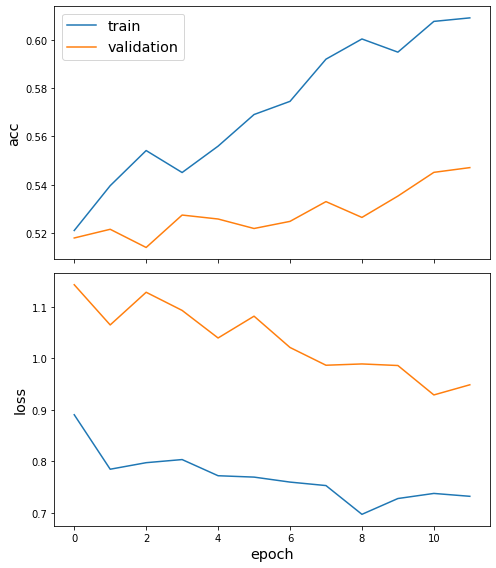

In [48]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [49]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

153/153 [==============================] - 3s 23ms/step - loss: 0.9301 - acc: 0.5514

Train Set Metrics of the trained model:
	loss: 0.9265
	acc: 0.5509

Test Set Metrics of the trained model:
	loss: 0.9301
	acc: 0.5514
